# Named Entity Recognition task using CRF

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import nltk
from nltk.tag import pos_tag
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
from sklearn_crfsuite import CRF, metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
import string
import warnings
warnings.filterwarnings('ignore')


def load_data_conll(file_path):
    """
    Load CoNLL formatted data from a file.

    Args:
        file_path (str): Path to the CoNLL file.

    Returns:
        list: A list of sentences, where each sentence is a tuple (words, tags).
    """
    myoutput, words, tags = [], [], []
    with open(file_path) as fh:
        for line in fh:
            line = line.strip()
            if "\t" not in line:
                # Sentence ended
                myoutput.append([words, tags])
                words, tags = [], []
            else:
                word, tag = line.split("\t")
                words.append(word)
                tags.append(tag)
    return myoutput


def sent2feats(sentence):
    """
    Extract features for each word in a sentence.

    Args:
        sentence (list): A list of words in a sentence.

    Returns:
        list: A list of dictionaries containing features for each word.
    """
    feats = []
    sen_tags = pos_tag(sentence)
    for i in range(len(sentence)):
        word = sentence[i]
        word_feats = {}
        # Word features
        word_feats['word'] = word
        if i == 0:
            word_feats["prevWord"] = word_feats["prevSecondWord"] = "<S>"
        elif i == 1:
            word_feats["prevWord"] = sentence[0]
            word_feats["prevSecondWord"] = "</S>"
        else:
            word_feats["prevWord"] = sentence[i - 1]
            word_feats["prevSecondWord"] = sentence[i - 2]
        if i == len(sentence) - 2:
            word_feats["nextWord"] = sentence[i + 1]
            word_feats["nextNextWord"] = "</S>"
        elif i == len(sentence) - 1:
            word_feats["nextWord"] = "</S>"
            word_feats["nextNextWord"] = "</S>"
        else:
            word_feats["nextWord"] = sentence[i + 1]
            word_feats["nextNextWord"] = sentence[i + 2]

        # POS tag features
        word_feats['tag'] = sen_tags[i][1]
        if i == 0:
            word_feats["prevTag"] = word_feats["prevSecondTag"] = "<S>"
        elif i == 1:
            word_feats["prevTag"] = sen_tags[0][1]
            word_feats["prevSecondTag"] = "</S>"
        else:
            word_feats["prevTag"] = sen_tags[i - 1][1]
            word_feats["prevSecondTag"] = sen_tags[i - 2][1]
        if i == len(sentence) - 2:
            word_feats["nextTag"] = sen_tags[i + 1][1]
            word_feats["nextNextTag"] = "</S>"
        elif i == len(sentence) - 1:
            word_feats["nextTag"] = "</S>"
            word_feats["nextNextTag"] = "</S>"
        else:
            word_feats["nextTag"] = sen_tags[i + 1][1]
            word_feats["nextNextTag"] = sen_tags[i + 2][1]

        feats.append(word_feats)
    return feats


def get_feats_conll(conll_data):
    """
    Extract features and labels from CoNLL formatted data.

    Args:
        conll_data (list): A list of sentences, where each sentence is a tuple (words, tags).

    Returns:
        tuple: A tuple containing two lists:
               - feats: Features for each sentence.
               - labels: Corresponding labels for each sentence.
    """
    feats = []
    labels = []
    for sentence in conll_data:
        feats.append(sent2feats(sentence[0]))
        labels.append(sentence[1])
    return feats, labels


def train_seq(X_train, Y_train, X_dev, Y_dev):
    """
    Train a Conditional Random Field (CRF) sequence model and evaluate its performance.

    Args:
        X_train (list): Features for training data.
        Y_train (list): Labels for training data.
        X_dev (list): Features for development/testing data.
        Y_dev (list): Labels for development/testing data.
    """
    crf = CRF(algorithm='lbfgs', c1=0.1, c2=10, max_iterations=50)
    crf.fit(X_train, Y_train)
    labels = list(crf.classes_)

    # Testing the model
    y_pred = crf.predict(X_dev)

    # Evaluate performance
    print("F1-score (weighted): ", metrics.flat_f1_score(Y_dev, y_pred, average='weighted', labels=labels))
    print("Classification Report:\n", metrics.flat_classification_report(Y_dev, y_pred, labels=labels, digits=3))

    # Plot confusion matrix
    plot_confusion_matrix(Y_dev, y_pred, labels=labels)


def plot_confusion_matrix(y_true, y_pred, labels):
    """
    Plot a confusion matrix for the predicted vs true labels.

    Args:
        y_true (list): True labels.
        y_pred (list): Predicted labels.
        labels (list): List of label names.
    """
    trues, preds = [], []
    for yseq_true, yseq_pred in zip(y_true, y_pred):
        trues.extend(yseq_true)
        preds.extend(yseq_pred)

    cm = confusion_matrix(trues, preds, labels=labels)

    # Plotting
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()


def main():
    """
    Main function to train and evaluate a CRF sequence model using CoNLL formatted data.
    """
    train_path = '/content/re3d-train.conll'
    test_path = '/content/re3d-test.conll'

    # Load the conll formatted data
    conll_train = load_data_conll(train_path)
    conll_dev = load_data_conll(test_path)

    print("Training a Sequence classification model with CRF")
    feats, labels = get_feats_conll(conll_train)
    devfeats, devlabels = get_feats_conll(conll_dev)

    # Train the sequence model
    train_seq(feats, labels, devfeats, devlabels)
    print("Done with sequence model")


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


Training a Sequence classification model with CRF
F1-score (weighted):  0.7731866228303304
Classification Report:
                      precision    recall  f1-score   support

                  O      0.826     0.973     0.894      3662
     B-Organisation      0.668     0.463     0.547       283
     I-Organisation      0.680     0.600     0.637       410
         B-Temporal      0.875     0.311     0.459        45
         I-Temporal      0.929     0.500     0.650        52
      B-Nationality      0.000     0.000     0.000        10
         B-Location      0.641     0.383     0.480       154
         I-Location      0.633     0.326     0.431       190
           B-Person      0.854     0.390     0.536       105
           I-Person      0.841     0.476     0.608       145
B-DocumentReference      0.000     0.000     0.000         8
I-DocumentReference      0.000     0.000     0.000        20
            B-Money      0.000     0.000     0.000         4
            I-Money      0.000

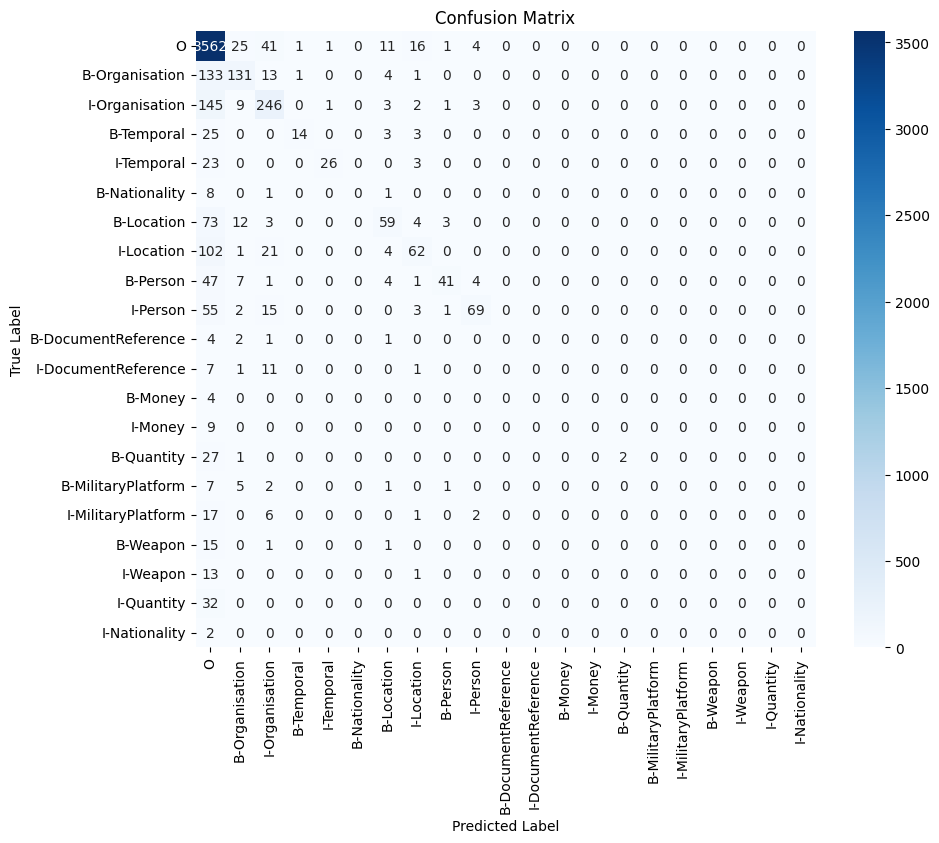

Done with sequence model


In [ ]:
main()